In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
#to ignore warnings
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
warnings.filterwarnings('ignore')

In [58]:
data = pd.read_csv("Features_Variant_1.csv")

In [59]:
column_names_updated = [
    "Page_Popularity_Likes", "Page_Checkins", "Page_Talking_About", "Page_Category",
    "Derived_1", "Derived_2", "Derived_3", "Derived_4", "Derived_5",
    "Derived_6", "Derived_7", "Derived_8", "Derived_9", "Derived_10",
    "Derived_11", "Derived_12", "Derived_13", "Derived_14", "Derived_15",
    "Derived_16", "Derived_17", "Derived_18", "Derived_19", "Derived_20",
    "Derived_21", "Derived_22", "Derived_23", "Derived_24", "Derived_25",
    "CC1_Total_Comments", "CC2_Comments_Last_24h", "CC3_Comments_48_to_24h",
    "CC4_Comments_First_24h", "CC5_CC2_CC3_Difference", "Base_Time",
    "Post_Length", "Post_Share_Count", "Post_Promotion_Status", "H_Local",
    "Published_Sunday", "Published_Monday", "Published_Tuesday",
    "Published_Wednesday", "Published_Thursday", "Published_Friday",
    "Published_Saturday", "BaseDate_Sunday", "BaseDate_Monday",
    "BaseDate_Tuesday", "BaseDate_Wednesday", "BaseDate_Thursday",
    "BaseDate_Friday", "BaseDate_Saturday", "Target_Comment_Volume"
]

data.columns = column_names_updated

In [60]:
data = data.drop("Post_Promotion_Status", axis=1)

In [61]:
published_day_mapping = {
    "Published_Sunday": "Sunday",
    "Published_Monday": "Monday",
    "Published_Tuesday": "Tuesday",
    "Published_Wednesday": "Wednesday",
    "Published_Thursday": "Thursday",
    "Published_Friday": "Friday",
    "Published_Saturday": "Saturday"
}

basedate_day_mapping = {
    "BaseDate_Sunday": "Sunday",
    "BaseDate_Monday": "Monday",
    "BaseDate_Tuesday": "Tuesday",
    "BaseDate_Wednesday": "Wednesday",
    "BaseDate_Thursday": "Thursday",
    "BaseDate_Friday": "Friday",
    "BaseDate_Saturday": "Saturday"
}

data['Published_Day'] = data[[*published_day_mapping.keys()]].idxmax(axis=1).map(published_day_mapping)
data['BaseDate_Day'] = data[[*basedate_day_mapping.keys()]].idxmax(axis=1).map(basedate_day_mapping)
data.drop(columns=list(published_day_mapping.keys()) + list(basedate_day_mapping.keys()), inplace=True)

# I think cyclic encoding is more efficient way than one-hot encoding
def encode_day(day_name):
    day_map = {
        'Monday': 0, 'Tuesday': 1, 'Wednesday': 2,
        'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6
    }
    day_idx = day_map.get(day_name, None)
    return (
        np.sin(2 * np.pi * day_idx / 7),
        np.cos(2 * np.pi * day_idx / 7)
    ) 

for col in ['Published_Day', 'BaseDate_Day']:
    data[[f"{col}_Sin", f"{col}_Cos"]] = pd.DataFrame(
        data[col].apply(encode_day).tolist(),
        index=data.index
    )

data.drop(['Published_Day', 'BaseDate_Day'], axis=1, inplace=True)

In [62]:
data['Hourly_Target_Volume'] = data['Target_Comment_Volume'] / data['H_Local']

First we split the data, as we dont want to leak the test data for calculating our features

In [63]:
train_df, test_df = train_test_split(
    data, test_size=0.2, random_state=42
)

### Feature: Comment Section Turned off
If the post has a multiple shares (25 percentile), but no comments have been tracked, the the comment section is marked as off. The same threshold value from the train dataset is also used for the test dataset.

In [64]:
share_thresh = np.percentile(train_df['Post_Share_Count'], 25)

mask_time_enough = train_df['Base_Time'] >= 10
mask_no_comments = train_df['CC1_Total_Comments'] == 0
mask_high_share  = train_df['Post_Share_Count']      > share_thresh

train_df['Comments_Section_Off'] = 0
train_df.loc[
    mask_time_enough & mask_no_comments & mask_high_share,
    'Comments_Section_Off'
] = 1

# test
mask_time_enough = test_df['Base_Time'] >= 10
mask_no_comments = test_df['CC1_Total_Comments'] == 0
mask_high_share  = test_df['Post_Share_Count']      > share_thresh

test_df['Comments_Section_Off'] = 0
test_df.loc[
    mask_time_enough & mask_no_comments & mask_high_share,
    'Comments_Section_Off'
] = 1

off_count_train = train_df['Comments_Section_Off'].sum()
off_count_test  = test_df['Comments_Section_Off'].sum()

print(f"Train set:   {off_count_train} posts with Comments_Section_Off = 1")
print(f"Test set:    {off_count_test} posts with Comments_Section_Off = 1")
train_df

Train set:   1174 posts with Comments_Section_Off = 1
Test set:    302 posts with Comments_Section_Off = 1


,Page_Popularity_Likes,Page_Checkins,Page_Talking_About,Page_Category,Derived_1,Derived_2,Derived_3,Derived_4,Derived_5,Derived_6,...,Post_Length,Post_Share_Count,H_Local,Target_Comment_Volume,Published_Day_Sin,Published_Day_Cos,BaseDate_Day_Sin,BaseDate_Day_Cos,Hourly_Target_Volume,Comments_Section_Off
15854,7564986,0,123241,12,0.0,35.0,3.365714,1.0,5.335913,0.0,...,142,2,24,1,0.433884,-0.900969,-0.433884,-0.900969,0.041667,0
29573,4913787,60,158828,9,0.0,1370.0,160.691589,110.5,187.755728,0.0,...,133,240,24,103,0.974928,-0.222521,0.433884,-0.900969,4.291667,0
2008,12802,4,31,29,0.0,18.0,2.305085,0.0,4.318876,0.0,...,794,1,24,0,0.433884,-0.900969,-0.433884,-0.900969,0.000000,0
12585,19926,0,41,72,0.0,16.0,4.080000,4.0,3.643295,0.0,...,64,1,24,0,-0.974928,-0.222521,0.781831,0.623490,0.000000,0
37205,78923,0,25345,24,7.0,135.0,69.571429,66.5,33.749528,1.0,...,74,3,24,1,-0.781831,0.623490,0.781831,0.623490,0.041667,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,4662,10,12,49,0.0,11.0,1.896104,1.0,2.515327,0.0,...,192,1,24,0,-0.974928,-0.222521,0.781831,0.623490,0.000000,0
11284,101655,0,33,8,0.0,7.0,0.663158,0.0,1.334644,0.0,...,74,1,24,0,-0.433884,-0.900969,-0.433884,-0.900969,0.000000,0
38158,54305,0,4830,67,0.0,281.0,10.368421,4.0,30.293669,0.0,...,0,83,24,0,0.781831,0.623490,0.974928,-0.222521,0.000000,0
860,6887,0,20,19,0.0,13.0,1.270677,0.0,2.077910,0.0,...,112,4,24,0,0.781831,0.623490,-0.433884,-0.900969,0.000000,1


### Features: Hourly Rates for past comment values
The CC1 to CC4 values are manipulates based on the base time, as f.e. for a basetime of 10 only 10 past hours were recoreded, not 24. To come up for this, the hourly rates are calculated as features, providing 4 new features.

In [65]:

train_df['Hourly_Rate_CC1'] = (
    train_df['CC1_Total_Comments']
    / np.maximum(train_df['Base_Time'], 1)
)
test_df['Hourly_Rate_CC1'] = (
    test_df['CC1_Total_Comments']
    / np.maximum(test_df['Base_Time'], 1)
)

# CC2 (last 24h)
train_df['Hourly_Rate_CC2'] = (
    train_df['CC2_Comments_Last_24h']
    / np.maximum(np.minimum(24, train_df['Base_Time']), 1)
)
test_df['Hourly_Rate_CC2'] = (
    test_df['CC2_Comments_Last_24h']
    / np.maximum(np.minimum(24, test_df['Base_Time']), 1)
)

# CC3 (24–48h)
train_df['Hourly_Rate_CC3'] = (
    train_df['CC3_Comments_48_to_24h']
    / np.maximum(
        np.minimum(24, train_df['Base_Time'] - 24),
        1
    )
)
test_df['Hourly_Rate_CC3'] = (
    test_df['CC3_Comments_48_to_24h']
    / np.maximum(
        np.minimum(24, test_df['Base_Time'] - 24),
        1
    )
)

# CC4 (first 24h)
train_df['Hourly_Rate_CC4'] = (
    train_df['CC4_Comments_First_24h']
    / np.maximum(
        np.minimum(24, train_df['Base_Time'] - 48),
        1
    )
)
test_df['Hourly_Rate_CC4'] = (
    test_df['CC4_Comments_First_24h']
    / np.maximum(
        np.minimum(24, test_df['Base_Time'] - 48),
        1
    )
)


### Feature: Aggregate on Page Category
Simple aggregate feature that output the average future comments per hour based on the category of the page that did the post.

In [66]:

cat_target = (
    train_df
    .groupby('Page_Category')['Hourly_Target_Volume']
    .mean()
    .reset_index()
    .rename(columns={'Hourly_Target_Volume': 'Category_Target_Mean'})
)
train_df = train_df.merge(cat_target, on='Page_Category', how='left')

# test: merge using train’s mapping
test_df = test_df.merge(cat_target, on='Page_Category', how='left')

### Features: Aggregates on Page Popularity, Checkins and Talking About
Bin these continiues variables into 30 groups. Based on the range of that group, calculate the average amount of future comments per hour

In [67]:

cont_feats = ['Page_Popularity_Likes', 'Page_Checkins', 'Page_Talking_About']
bin_edges = {}
bin_means = {}

for feat in cont_feats:
    bin_col   = feat + '_bin'
    mean_col  = feat + '_Bin_Target_Mean'

    # --- train: q‐cut, mean, map, save edges/measures, drop bin col
    train_df[bin_col] = pd.qcut(
        train_df[feat], q=30, duplicates='drop'
    )
    bmean = train_df.groupby(bin_col)['Hourly_Target_Volume'].mean()
    train_df[mean_col] = train_df[bin_col].map(bmean)
    bin_edges[feat] = train_df[bin_col].cat.categories
    bin_means[feat] = bmean
    train_df.drop(columns=[bin_col], inplace=True)

    # --- test: cut on train’s edges, map train’s means, drop bin col
    test_df[bin_col] = pd.cut(
        test_df[feat],
        bins=bin_edges[feat]
    )
    test_df[mean_col] = test_df[bin_col].map(bin_means[feat])
    test_df.drop(columns=[bin_col], inplace=True)

### Feature: Ratio between CommentsLast 24 hours and Future Comments
Calculate the average ratio between the hourly amount of future comments and the hourly amount of comments from the last 24 hours. This is done on aggregates, so that we can also calculate this feature on the test dataset, without leaking data. Therefore, the aggregate is done based on Page_Talking_About with 30 bins: Meaning we will have 30 distinct ratios assigned to each bin.

If the comment section is turned off, the value is simply set to 0.

In [68]:

import numpy as np
import pandas as pd

# --- TRAIN: compute individual ratio & aggregate ---
# 1) compute future and past rates
future_rate = train_df['Target_Comment_Volume'] / train_df['H_Local']
past_rate   = train_df['Hourly_Rate_CC2']

# 2) individual ratio = future_rate / past_rate, but zero if past_rate==0
train_df['Ratio_Indiv'] = np.where(
    past_rate == 0,
    0,
    future_rate / past_rate
)

# 3) exclude “off” rows from aggregation
train_df.loc[train_df['Comments_Section_Off'] == 1, 'Ratio_Indiv'] = np.nan

# 4) create 30 quantile bins on Page_Talking_About (train only)
train_df['PTA_ratio_bin'] = pd.qcut(
    train_df['Page_Talking_About'],
    q=10,
    duplicates='drop'
)

# 5) compute mean ratio per bin (NaNs ignored)
ratio_group = (
    train_df
    .groupby('PTA_ratio_bin')['Ratio_Indiv']
    .mean()
    .reset_index()
    .rename(columns={'Ratio_Indiv': 'Ratio_Agg_Past24h_vs_Future'})
)

# 6) merge aggregate back onto train and zero‑out “off” rows
train_df = train_df.merge(ratio_group, on='PTA_ratio_bin', how='left')
train_df.loc[train_df['Comments_Section_Off'] == 1, 'Ratio_Agg_Past24h_vs_Future'] = 0

# 7) save the bin edges & clean up
ratio_bins = train_df['PTA_ratio_bin'].cat.categories
train_df.drop(columns=['Ratio_Indiv', 'PTA_ratio_bin'], inplace=True)


# --- TEST: apply train‑derived aggregates ---
# 1) bin test rows using train’s edges
test_df['PTA_ratio_bin'] = pd.cut(
    test_df['Page_Talking_About'],
    bins=ratio_bins
)

# 2) merge the train‑computed aggregates
test_df = test_df.merge(ratio_group, on='PTA_ratio_bin', how='left')

# 3) fill missing & zero‑out “off” rows
test_df['Ratio_Agg_Past24h_vs_Future'] = test_df['Ratio_Agg_Past24h_vs_Future'].fillna(0)
test_df.loc[test_df['Comments_Section_Off'] == 1, 'Ratio_Agg_Past24h_vs_Future'] = 0

# 4) clean up
test_df.drop(columns=['PTA_ratio_bin'], inplace=True)

In [69]:
X_train = train_df.drop(columns='Target_Comment_Volume')
y_train = train_df['Target_Comment_Volume']

X_test  = test_df.drop(columns='Target_Comment_Volume')
y_test  = test_df['Target_Comment_Volume']

Simple Baseline Model:

Predict the amount of comments for the next t hours in the following manner:

Comments per hour of the last 24 hours * t * ratio (see above, ratio between comments per hour for last 24 hours / comments per hour for the future)


In [70]:
def simple_predict(df):
    return df['Hourly_Rate_CC2'] * df['H_Local'] * df['Ratio_Agg_Past24h_vs_Future']

y_pred = simple_predict(X_test)

# 2. Evaluation metrics
mae = mean_absolute_error(y_test, y_pred)

# 3. Print results
print(f"Mean Absolute Error (MAE): {mae:.2f}")

Mean Absolute Error (MAE): 5.65


                                       Target_Comment_Volume  \
Target_Comment_Volume                               1.000000   
Hourly_Target_Volume                                0.997846   
Comments_Section_Off                               -0.038798   
Hourly_Rate_CC1                                     0.724554   
Hourly_Rate_CC2                                     0.729268   
Hourly_Rate_CC3                                     0.085404   
Hourly_Rate_CC4                                     0.409975   
Category_Target_Mean                                0.148623   
Page_Popularity_Likes_Bin_Target_Mean               0.198013   
Page_Checkins_Bin_Target_Mean                       0.043958   
Page_Talking_About_Bin_Target_Mean                  0.249198   
Ratio_Agg_Past24h_vs_Future                         0.170557   

                                       Hourly_Target_Volume  \
Target_Comment_Volume                              0.997846   
Hourly_Target_Volume                     

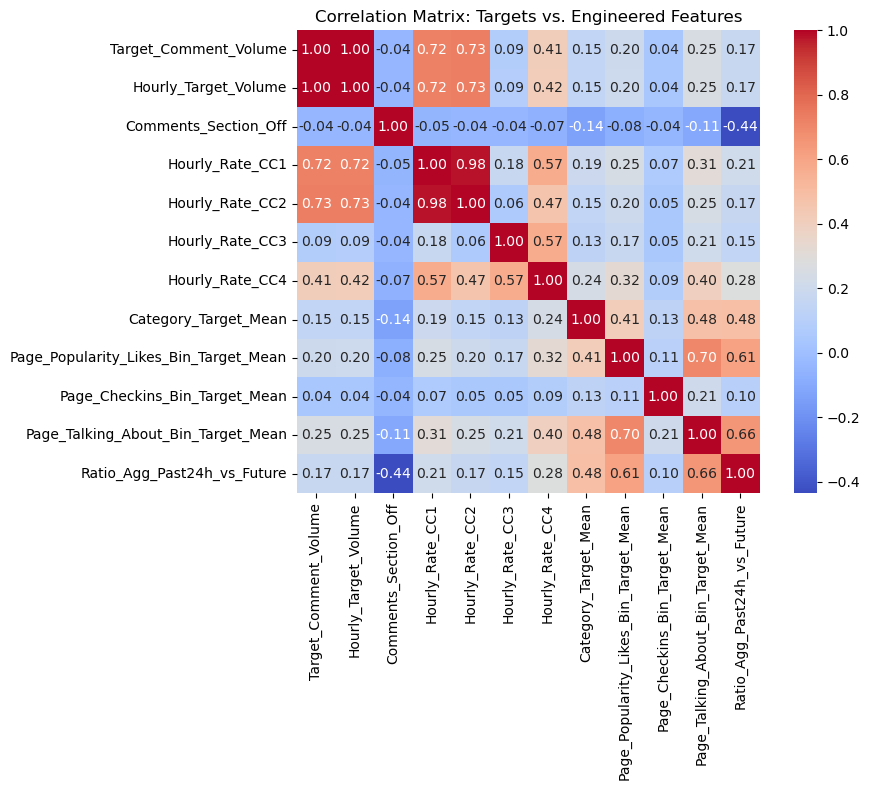

In [71]:

# 2) Select the newly added features + targets
corr_cols = [
    'Target_Comment_Volume',
    'Hourly_Target_Volume',
    'Comments_Section_Off',
    'Hourly_Rate_CC1',
    'Hourly_Rate_CC2',
    'Hourly_Rate_CC3',
    'Hourly_Rate_CC4',
    'Category_Target_Mean',
    'Page_Popularity_Likes_Bin_Target_Mean',
    'Page_Checkins_Bin_Target_Mean',
    'Page_Talking_About_Bin_Target_Mean',
    'Ratio_Agg_Past24h_vs_Future'
]

# 3) Compute correlation matrix
corr_matrix = train_df[corr_cols].corr()

# 4) Print and plot
print(corr_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Matrix: Targets vs. Engineered Features")
plt.tight_layout()
plt.show()

In [72]:
X_train = train_df.drop(['Target_Comment_Volume', 'Hourly_Target_Volume'], axis=1)
y_train = train_df['Target_Comment_Volume']

Feature Selection with Lasso Requrilazation

In [73]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel

numeric_feats = X_train.select_dtypes(include=[np.number]).columns
X_train_num = X_train[numeric_feats]
X_test_num  = X_test[numeric_feats]

# 2) Scale (for Lasso)
scaler_lasso = StandardScaler()
X_train_scaled_lasso = scaler_lasso.fit_transform(X_train_num)
X_test_scaled_lasso  = scaler_lasso.transform(X_test_num)

# 3) Fit LassoCV to select features
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train_scaled_lasso, y_train)

# 4) Select features above a certain threshold (e.g. mean)
selector = SelectFromModel(lasso, prefit=True, threshold='mean')
X_train_selected = selector.transform(X_train_scaled_lasso)
X_test_selected  = selector.transform(X_test_scaled_lasso)

# Optionally: get the names of selected features
selected_idx = selector.get_support()
selected_feats = numeric_feats[selected_idx]
print("Lasso selected features:")
for f in selected_feats:
    print("  ", f)

Lasso selected features:
   Derived_5
   Derived_9
   Derived_14
   CC2_Comments_Last_24h
   Base_Time
   Post_Share_Count
   Hourly_Rate_CC2


Dimensionality Reduction with PCA

In [74]:
pca = PCA(n_components=0.95, svd_solver='full', random_state=42)
X_train_pca = pca.fit_transform(X_train_selected)
X_test_pca  = pca.transform(X_test_selected)

print(f"\nAfter Lasso: {X_train_selected.shape[1]} features")
print(f"After PCA: {X_train_pca.shape[1]} principal components")


After Lasso: 7 features
After PCA: 6 principal components


In [75]:
data.to_pickle('DataWithFeatureEngineering.pkl')